# LOGML

In [2]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 407 kB 30.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=62e4dbe9fa3da4c2ba0141a639b80ebca547cfc1fe7f219fd90813789c03fbfb
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [4]:
import torch
import torch_geometric as tg

from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

import torch.nn.functional as F


ModuleNotFoundError: ignored

## Data Handling

In [ ]:
# Presettings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_PATH = "drive/MyDrive/'Colab Notebooks'/sushi-posets"
args = {
    "TRAIN_N": 3500,
    "TEST_N": 500,
    "VAL_N": 1000,
    "BATCH_SIZE": 20
}

In [ ]:
import networkx as nx
import numpy as np

def create_hasse(data):
    # INPUT: data = trainset[0] (tensor)
    # Create directed graph
    G = nx.DiGraph()
    G = nx.from_edgelist(data.zeta_index.numpy().transpose(), G)

    # Create Hasse
    hasse = []
    for source in G.nodes:
        for target in G.nodes:
            if len(list(nx.all_simple_paths(G, source, target))) == 1:
                hasse.append([source, target])

    # Format Hasse
    return np.array(hasse).transpose() # OUTPUT in np.array

In [ ]:
# Load dataset
dataset = torch.load(DATA_PATH)

# Append Hasse Matrix
for data_ele in dataset:
    data_ele.hasse_index = torch.tensor(create_hasse(data_ele))

# Split dataset
trainset, testset, valset = random_split(dataset, [args["TRAIN_N"], args["TEST_N"], args["VAL_N"]])

FileNotFoundError: ignored

In [ ]:
train_loader = DataLoader(trainset, args["BATCH_SIZE"])
test_loader = DataLoader(testset, args["BATCH_SIZE"])

## Model

In [ ]:
from torch_geometric.nn import MLP, GINConv, global_add_pool

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            mlp = MLP([in_channels, hidden_channels, hidden_channels])
            self.convs.append(GINConv(nn=mlp, train_eps=False))
            in_channels = hidden_channels

        self.mlp = MLP([hidden_channels, hidden_channels, out_channels], dropout=0.5, batch_norm=False)

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        x = global_add_pool(x, batch)
        return self.mlp(x)

## Learning with the zeta matrix

In [ ]:
hidden_channels = 32
num_classes = 2
num_features = 7
num_layers = 5
lr = .01

logging = []

model = Net(num_features, hidden_channels, num_classes,
            num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.zeta_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
    return total_loss #/ len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x.float(), data.zeta_index, data.batch).argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

num_epochs = 50

for epoch in range(1, num_epochs + 1):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    logging.append({"Epoch": epoch, "Loss": loss, "Train": train_acc, "Test": test_acc})


### Visualize learning

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

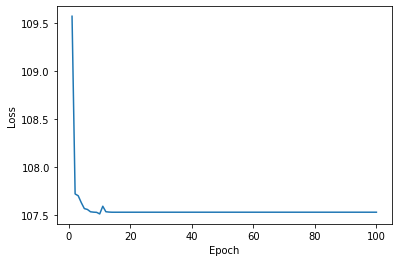

In [ ]:
import pandas as pd
import seaborn as sb

df = pd.DataFrame(logging)
sb.lineplot(data = df, x="Epoch", y="Loss")

<AxesSubplot:xlabel='Epoch', ylabel='Train'>

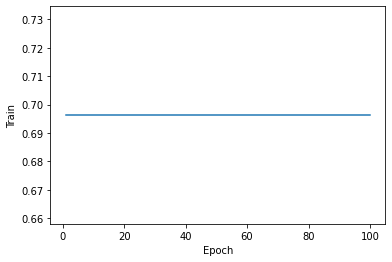

In [ ]:
sb.lineplot(data = df, x="Epoch", y="Train")


<AxesSubplot:xlabel='Epoch', ylabel='Test'>

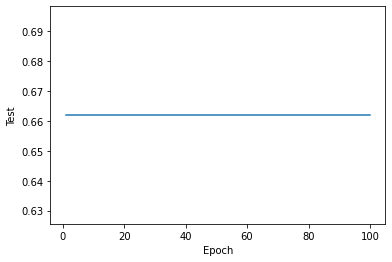

In [ ]:
sb.lineplot(data = df, x="Epoch", y="Test")


## Learning with the Hasse Diagramm

In [ ]:
hidden_channels = 32
num_classes = 2
num_features = 7
num_layers = 5
lr = .01

logging = []

model = Net(num_features, hidden_channels, num_classes,
            num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.float(), data.hasse_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
    return total_loss #/ len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x.float(), data.hasse_index, data.batch).argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

num_epochs = 50

for epoch in range(1, num_epochs + 1):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    logging.append({"Epoch": epoch, "Loss": loss, "Train": train_acc, "Test": test_acc})


<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

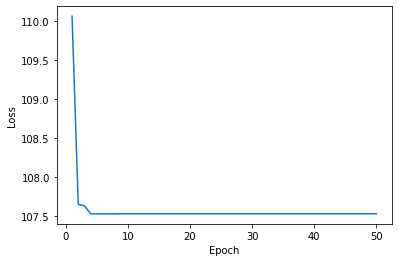

In [ ]:
df = pd.DataFrame(logging)
sb.lineplot(data = df, x="Epoch", y="Loss")

<AxesSubplot:xlabel='Epoch', ylabel='Train'>

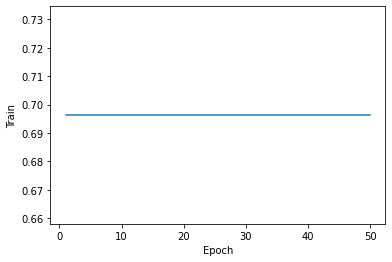

In [ ]:
sb.lineplot(data = df, x="Epoch", y="Train")


<AxesSubplot:xlabel='Epoch', ylabel='Test'>

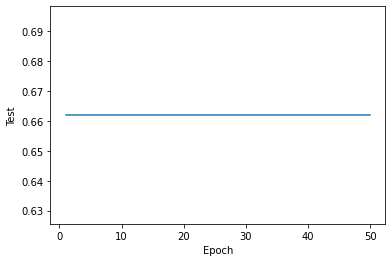

In [ ]:
sb.lineplot(data = df, x="Epoch", y="Test")
